In [1]:
import torch
import phate
import scprep
import numpy as np

In [2]:
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=5, branch_length=30)

In [3]:
phate_operator = phate.PHATE(random_state=42)
tree_phate = phate_operator.fit_transform(tree_data)

Calculating PHATE...
  Running PHATE on 150 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 0.16 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.08 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.11 seconds.
Calculated PHATE in 0.36 seconds.


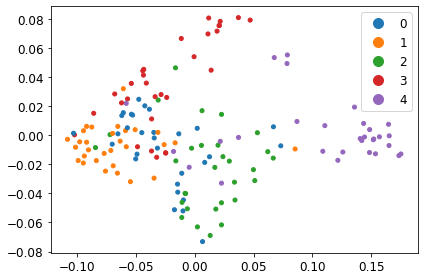

In [4]:
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters)

In [5]:
X = torch.tensor(tree_data, requires_grad=True)

In [6]:
n = 11

In [7]:
random_indices = np.random.randint(tree_data.shape[0], size=n)

In [8]:
phate_operator = phate.PHATE(knn=5, decay=20, t=150, random_state=42)
tree_phate = phate_operator.fit_transform(tree_data[random_indices])

Calculating PHATE...
  Running PHATE on 11 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 0 and 7, 1 and 4. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 0.21 seconds.
  Calculated graph and diffusion operator in 0.23 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.24 seconds.


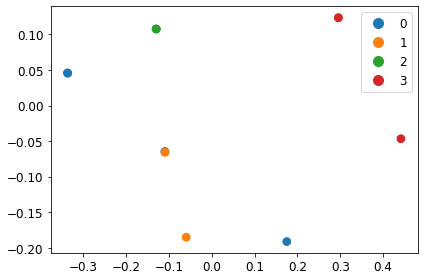

In [9]:
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters[random_indices])

In [10]:
%%time
def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")
    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)
    kernel = gaussian_kernel(dists)
    D_flat = kernel.sum(axis=0)
    D = torch.diagflat(D_flat ** -0.5)
    p = (D) @ kernel @ (D)
    L, Q = torch.linalg.eigh(p)
    assert torch.allclose(Q @ torch.diagflat(L) @ Q.T,p)
    # Truncate to keep gradients okay
    mask = L < 0.1
    L = L[~mask]
    Q = Q[:, ~mask]
    pt = torch.diagflat(D_flat ** -0.5) @ Q @ torch.diagflat(torch.pow(L, t)) @ Q.T @ torch.diagflat(D_flat ** 0.5)
    #print(pt)
    log_p = torch.log(pt)
    return log_p

#log_P = torch_phate(X[random_indices])
#assert torch.abs(torch.exp(log_P[0]).sum() - 1) < 1e-2

def torch_phate_fixed_data(bandwidth, t):
    return torch_phate(X[random_indices], bandwidth=bandwidth, t=t)

def calc_fischer(bandwidth, t):
    bandwidth = torch.tensor(bandwidth, requires_grad=True, dtype=torch.float64)
    t = torch.tensor(t, requires_grad=True, dtype=torch.float64)
    log_P = torch_phate_fixed_data(bandwidth, t)
    J = torch.autograd.functional.jacobian(torch_phate_fixed_data, (bandwidth, t))
    # shape: N_output [N x N], input [N x D]
    J = torch.stack(J)
    fischer = J.unsqueeze(1) * J.unsqueeze(0) * torch.exp(log_P)
    fischer = fischer.sum(axis=-1).mean(axis=-1)
    return fischer

calc_fischer(100, 7)

def local_volume(bandwidth, t):
    return torch.sqrt(torch.abs(torch.linalg.det(calc_fischer(bandwidth, t))))

local_volume(100, 7)

bandwidths = np.linspace(50, 150, 11)
ts = np.linspace(1, 15, 29)
bv, tv = np.meshgrid(bandwidths, ts)

fs = []
for b, t in zip(bv.flatten(), tv.flatten()):
    fs.append(calc_fischer(b, t))
fs = torch.stack(fs)
print(fs.shape)

torch.Size([319, 2, 2])
CPU times: user 20.9 s, sys: 65.2 ms, total: 21 s
Wall time: 22.9 s


In [11]:
fs

tensor([[[3.4228e-04, 5.0326e-03],
         [5.0326e-03, 8.1808e-02]],

        [[2.9868e-04, 5.8314e-03],
         [5.8314e-03, 1.2645e-01]],

        [[2.4917e-04, 6.2235e-03],
         [6.2235e-03, 1.7265e-01]],

        ...,

        [[2.5444e-06, 3.5066e-06],
         [3.5066e-06, 1.6259e-05]],

        [[1.4949e-06, 7.8443e-07],
         [7.8443e-07, 4.9772e-06]],

        [[1.0941e-06, 1.3227e-07],
         [1.3227e-07, 1.4713e-06]]], dtype=torch.float64,
       grad_fn=<StackBackward0>)

In [12]:
volumes = torch.sqrt(torch.abs(torch.linalg.det(fs)))

In [13]:
volumes.shape

torch.Size([319])

In [14]:
coords = (np.array([bv.flatten(), tv.flatten()]).T)

Text(0.5, 1.0, 'Volume Grid')

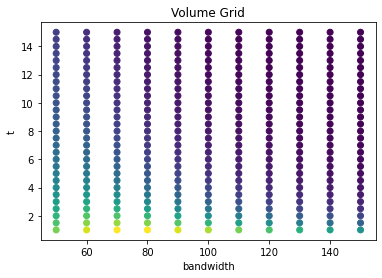

In [15]:
import matplotlib.pyplot as plt
plt.scatter(coords[:,0], coords[:,1], c=volumes.detach().numpy())
plt.xlabel("bandwidth")
plt.ylabel("t")
plt.title("Volume Grid")

Text(0.5, 1.0, 'Volume Grid')

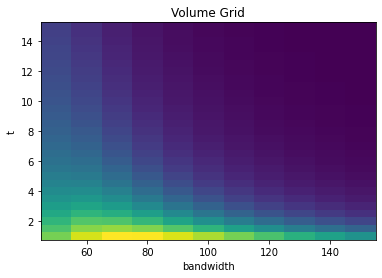

In [16]:
plt.pcolormesh(bandwidths, ts, volumes.detach().numpy().reshape(bv.shape))
plt.xlabel("bandwidth")
plt.ylabel("t")
plt.title("Volume Grid")

In [24]:
# Warp the grid based on the inner product?

In [25]:
log_P = torch_phate(X[random_indices])
assert torch.abs(torch.exp(log_P[0]).sum() - 1) < 1e-2


J = torch.autograd.functional.jacobian(torch_phate, X[random_indices])
Jt = J.transpose(1, 2)

fischer_information = torch.sum(J * Jt * torch.exp(log_P[:, :, None, None]), dim=1)
fischer_information_flat = fischer_information.reshape(n, -1)

print(fischer_information_flat.shape)
#phate_operator_inf = phate.PHATE(knn=5, decay=20, t=150, random_state=42)
#tree_phate_inf = phate_operator_inf.fit_transform(fischer_information_flat.detach().numpy())

torch.Size([11, 110])


In [27]:
fischer_information.shape

torch.Size([11, 11, 10])